In [178]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


In [179]:
# --- Define the stock and the time period ---
stock_ticker = 'RELIANCE.NS'
start_date = '2015-01-01'
end_date = '2024-12-31'

In [180]:
# --- Fetch the data ---
print(f"Downloading data for {stock_ticker}...")
stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
print("Data downloaded successfully!")

C:\Users\HP\AppData\Local\Temp\ipykernel_16584\3175145580.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!


In [181]:
data = stock_data.copy()

# --- 1. Create the Target Variable: Daily Percentage Return ---
# Instead of predicting the 'Close' price, we predict its percentage change from the previous day.
data['Target_Return'] = data['Close'].pct_change()


In [182]:
# --- 2. Create Stationary Features ---
# The model needs features that are also independent of the absolute price level.

# OHLC prices are made relative to the previous day's close.
data['Open_vs_PrevClose'] = (data['Open'] - data['Close'].shift(1)) / data['Close'].shift(1)
data['High_vs_PrevClose'] = (data['High'] - data['Close'].shift(1)) / data['Close'].shift(1)
data['Low_vs_PrevClose'] = (data['Low'] - data['Close'].shift(1)) / data['Close'].shift(1)

# Moving averages are made relative to the current closing price to show the trend's strength.
data['MA_20_Ratio'] = data['Close'].rolling(window=20).mean() / data['Close']
data['MA_50_Ratio'] = data['Close'].rolling(window=50).mean() / data['Close']

# Volatility is already a percentage, so it's relatively stationary.
data['Volatility_20'] = data['Close'].pct_change().rolling(window=20).std()

# We also need the previous day's close to convert our predicted return back into a price later.
data['Prev_Close'] = data['Close'].shift(1)

In [183]:
# --- 3. Shift the Target ---
# IMPORTANT: We are predicting tomorrow's return. Therefore, we must shift our target variable
# back by one day. This ensures we are using today's data to predict tomorrow's outcome.
y = data['Target_Return'].shift(-1)

In [184]:
# --- 4. Clean the Dataset ---
# Drop the original columns and any rows with NaN values created by our operations.
X = data.drop(['Open', 'High', 'Low', 'Close', 'Target_Return'], axis=1)
X.dropna(inplace=True)

# Align the target 'y' with the cleaned 'X' by dropping NaNs from y as well
y = y.loc[X.index]

# The .shift(-1) on 'y' created a NaN at the very last row. We must remove it
# from both y and X to ensure perfect alignment before splitting.
# This is the most robust way to handle the final NaN.
y.dropna(inplace=True)
X = X.loc[y.index]

print("\n--- Transformed Feature Set (X) ---")
print(X.head())

print("\n--- Transformed Target (y) - Daily Return ---")
print(y.head())


--- Transformed Feature Set (X) ---
Price           Volume Open_vs_PrevClose High_vs_PrevClose Low_vs_PrevClose  \
Ticker     RELIANCE.NS                                                        
Date                                                                          
2015-03-16    13839990          0.001647          0.004529        -0.011528   
2015-03-17    19070082          0.010034          0.021138        -0.001306   
2015-03-18     9269885          0.000175          0.017973        -0.002509   
2015-03-19    13934612          0.007943          0.009267        -0.016750   
2015-03-20    10405717          0.002044          0.005840        -0.008819   

Price      MA_20_Ratio MA_50_Ratio Volatility_20  Prev_Close  
Ticker                                                        
Date                                                          
2015-03-16    1.033684    1.045267      0.016399  182.637604  
2015-03-17    1.012350    1.026548      0.016843  180.918869  
2015-03-18    0

In [185]:
#### 5. Time-Series Train-Test Split
split_percentage = 0.85
split_index = int(len(X) * split_percentage)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")


Training set size: 2053 samples
Testing set size: 363 samples


In [186]:
model = RandomForestRegressor(n_estimators=150, min_samples_split=10, random_state=42, n_jobs=-1)

print("\nTraining the Random Forest Regressor on stationary features...")
model.fit(X_train, y_train)
print("Model training complete!")

predicted_returns = model.predict(X_test)


Training the Random Forest Regressor on stationary features...
Model training complete!


In [187]:
# Convert predicted returns back to prices
prev_close_test = X_test['Prev_Close']
predicted_prices = prev_close_test * (1 + predicted_returns)

# Get the corresponding actual prices
actual_prices = stock_data.loc[y_test.index]['Close']


In [188]:
# Evaluate the model's performance
r2_returns = r2_score(y_test, predicted_returns)
mae_price = mean_absolute_error(actual_prices, predicted_prices)
rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print("\n--- Improved Model Evaluation ---")
print(f"R-squared (R²) on Returns: {r2_returns:.4f}")
print(f"Mean Absolute Error (MAE) on Price: ₹{mae_price:.2f}")
print(f"Root Mean Squared Error (RMSE) on Price: ₹{rmse_price:.2f}")
print("-----------------------------------")


--- Improved Model Evaluation ---
R-squared (R²) on Returns: -0.2349
Mean Absolute Error (MAE) on Price: ₹13.95
Root Mean Squared Error (RMSE) on Price: ₹18.84
-----------------------------------


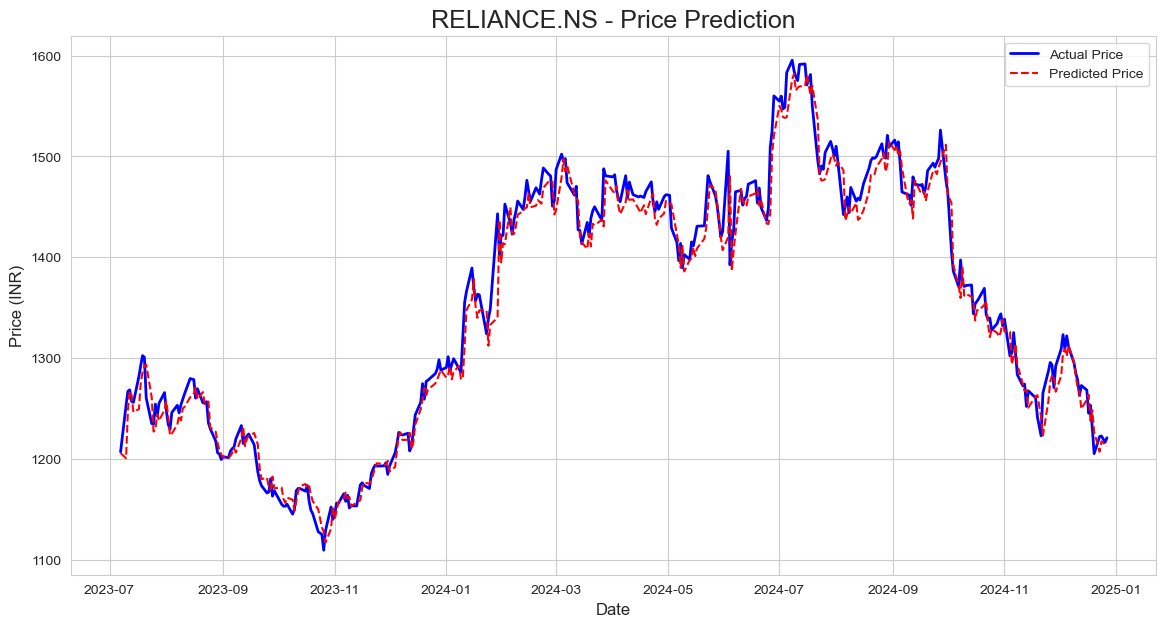

In [189]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices.index, actual_prices, label='Actual Price', color='blue', linewidth=2)
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Price', color='red', linestyle='--')
plt.title(f'{stock_ticker} - Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (INR)', fontsize=12)
plt.legend()
plt.show()